**ПЛАН РАБОТЫ**:

1. Загрузить и подготовить данные;
2. Выполнить ресемплирование данных по одному часу и провести анализ;
3. Обучить разные модели, выбрав оптимальную. Требование - модель должна ошибатьcя не более, чем на 48 минут; 
4. Проверить модель на тестовой выборке.

## Подготовка

Для начала загрузим необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter('ignore')

Загрузим и прочитаем файл:

In [2]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])

Выведим на экран первые строки датасета:

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим общую информацию:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


При загрузке датасета мы изменили тип данных Datetime с object на datetime64 и установили индекс таблицы равным столбцу Datetime. Данные в таблице представлены за период с 2018-03-01 по 2018-08-31.

Проверим, в хронолигическом ли порядке расположены дата и время: 

In [5]:
data.sort_index(inplace=True)
data.index.is_monotonic

True

Все в порядке. Данные упорядочены во времени.

# Вывод

Мы загрузили и прочитали файл. Подготовили данные для анализа временного ряда. 

## Анализ

Выполним рессемплирование, выбрав интервал в один час:

In [6]:
data=data['2018-03':'2018-08'].resample('1H').sum()

Посмотрим на статистику:

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


В 50% случаев число заказов в час составляет 78. 

Построим график временного ряда со скользящими стандартным отклонением и средним значением:

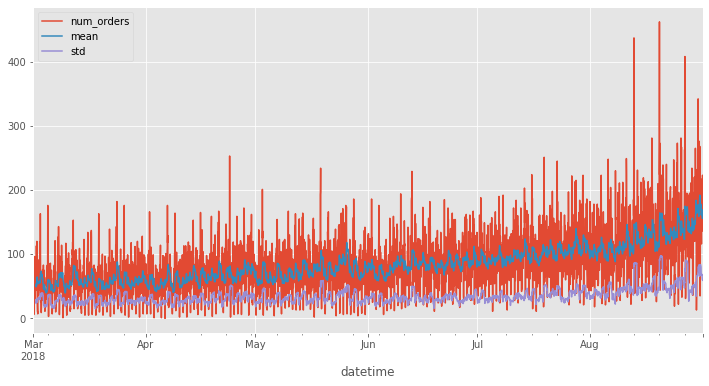

In [8]:
data_analysis = data.copy()

data_analysis['mean'] = data_analysis['num_orders'].rolling(20).mean()
data_analysis['std'] = data_analysis['num_orders'].rolling(20).std()

data_analysis.plot(figsize=(12,6))
plt.show()

Временной ряд показывает устойчиво возрастающий тренд. С августа увеличивается число заказов такси - время окончания отпускного периода. 

Стандартное отклонение изменяется не настолько сильно. В то время, как среднее значение очевидно указывает на нестационарность временного ряда.

Разберём тренды и сезонность:

In [9]:
decomposed = seasonal_decompose(data['num_orders'])

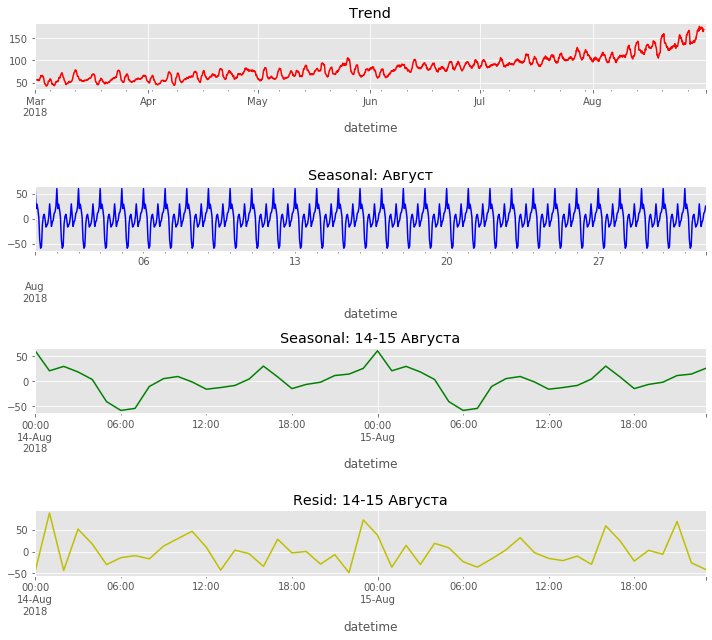

In [10]:
plt.figure(figsize=(10, 9))

plt.subplot(411)
decomposed.trend['2018-03':'2018-08'].plot(ax=plt.gca(), color = 'r')
plt.title('Trend')

plt.subplot(412)
decomposed.seasonal['2018-08':'2018-08'].plot(ax=plt.gca(), color = 'b')
plt.title('Seasonal: Август')

plt.subplot(413)
decomposed.seasonal['2018-08-14':'2018-08-15'].plot(ax=plt.gca(), color = 'g')
plt.title('Seasonal: 14-15 Августа')

plt.subplot(414)
decomposed.resid['2018-08-14':'2018-08-15'].plot(ax=plt.gca(), color = 'y')
plt.title('Resid: 14-15 Августа')

plt.tight_layout()

График тренда отражает стабильное увеличение заказов такси на протяжении всего периода. 

Сезонность для более удобной визуализации выведена в двух диапазонах: за весь август и за период 14-15 августа. График месяца отражает четкую цикличность заказов изо дня в день. 

Наибольший интерес представляет график заказа такси в течение суток. Посмотрим на него ближе:

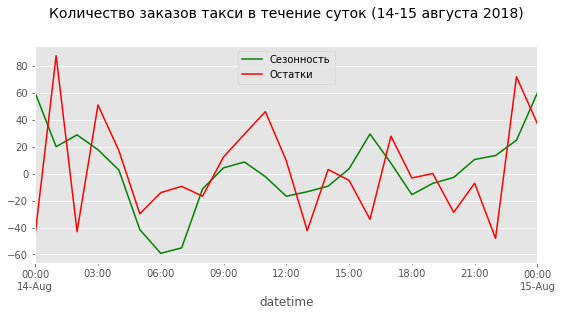

In [11]:
plt.title('Количество заказов такси в течение суток (14-15 августа 2018)', y=1.1, fontsize=14)
decomposed.seasonal['2018-08-14-00:00:00':'2018-08-15-00:00:00'].plot(figsize=(9,4), color='g', label='Сезонность')
decomposed.resid['2018-08-14-00:00:00':'2018-08-15-00:00:00'].plot(figsize=(9,4), color='r', label='Остатки')
plt.legend()
plt.show()

Как видно из графика больше всего вызовов приходится на 12 часов ночи. Спад - 6 утра. Еще один пик наблюдаем примерно в 16:00. По остаткам видно, как много выбросов.

# Вывод

В результате анализа временного ряда было установлено следующее:

1. Среднее количество заказов такси в час составляет 78; 
2. На протяжении всего исследуемого периода наблюдается тенденция к увеличению числа заказов - рост тренда;
3. Данные отражают "сезонность" : наибольшая загруженность приходится на 12 часов ночи и 4-5 часов вечера, наименьшая - в 6-7 утра.

## Обучение

Для обучения выберем простой алгоритм:

* `LinearRegression`

и несколько ансамблиевых:
*  `RandomForestRegressor`
* `CatBoostRegressor`
* `LGBMRegressor`

Подготовим данные для обучения. 

Напишем функцию для создания признаков: 

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['minute'] = data.index.minute
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Подберем аргументы функции так, чтобы достичь качества метрики не менее 48:

In [13]:
make_features(data, 20, 24)

Разобьем данные на обучающую, валидационную и тестовую выборки:

In [14]:
train, supp = train_test_split(data, test_size=.25, shuffle=False)
valid, test = train_test_split(supp, test_size=.40, shuffle=False)

In [15]:
train.dropna(inplace=True)

In [16]:
print('Размер обучающей выборки:', train.shape[0])
print('Размер валидационной выборки:', valid.shape[0])
print('Размер тестовой выборки:', test.shape[0]) 

Размер обучающей выборки: 3288
Размер валидационной выборки: 662
Размер тестовой выборки: 442


Тестовая выборка составляет примерно 10% от исходной. Размерность соблюдена верно.

Напечатаем минимальные и максимальные значения индексов выборок, чтобы убедиться в корректности деления:

In [17]:
print(train.index.min(), train.index.max())
print(valid.index.min(), valid.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-16 23:00:00
2018-07-17 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Все в порядке, данные разбиты корректно.

Для каждой выборки определим признаки и целевой признак:

In [18]:
X_train = train.drop(['num_orders'], axis=1)
X_valid = valid.drop(['num_orders'], axis=1)
X_test = test.drop(['num_orders'], axis=1)

y_train = train['num_orders']
y_valid = valid['num_orders']
y_test = test['num_orders']

Приступим к обучению.

### LinearRegression()

In [19]:
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)
LR_preds = LR_model.predict(X_valid)
LR_rmse = mean_squared_error(y_valid, LR_preds)**0.5
print('RMSE: {:.2f}'.format(LR_rmse))

RMSE: 34.92


### RandomForestRegressor()

In [20]:
RF_model=RandomForestRegressor(max_depth=8, n_estimators=300)
RF_model.fit(X_train, y_train)
RF_preds = RF_model.predict(X_valid)
RF_rmse = mean_squared_error(y_valid, RF_preds)**0.5
print('RMSE: {:.2f}'.format(RF_rmse))

RMSE: 33.18


### CatBoostRegressor()

In [21]:
Cat_model = CatBoostRegressor(depth=6, iterations=300, learning_rate=0.05, loss_function='RMSE',  verbose=0)
Cat_model.fit(X_train, y_train)
Cat_preds = Cat_model.predict(X_valid)
Cat_rmse = mean_squared_error(y_valid, Cat_preds)**0.5
print('RMSE: {:.2f}'.format(Cat_rmse))

RMSE: 31.75


### LGBMRegressor()

In [22]:
LG_model = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate = 0.05, objective='RMSE', verbose=0)
LG_model.fit(X_train, y_train)
LG_preds = LG_model.predict(X_valid)
LG_rmse = mean_squared_error(y_valid, LG_preds).mean()**0.5
print('RMSE: {:.2f}'.format(LG_rmse))

RMSE: 30.86


Оценим модель на качество с помощью прогнозирования нового значение  𝑥(𝑡)  предыдущим значением ряда  𝑥(𝑡−1):

In [23]:
pred_previous = valid.shift()
pred_previous.iloc[0]= train.iloc[train.shape[0]-1] 
pred_valid_rmse = mean_squared_error(valid, pred_previous)**0.5
print('RMSE: {:.2f}'.format(pred_valid_rmse))

RMSE: 40.30


RMSE всех моделей значительно лучше данного результата - проверка на качество пройдена.

Выведим результат в одну таблицу:

In [24]:
rmse_valid = pd.DataFrame([pred_valid_rmse, LR_rmse, RF_rmse,  Cat_rmse, LG_rmse],
                       columns = ['RMSE_valid'], 
                       index = ['Baseline','LinearRegressor','RandomForestRegressor', 
                                'CatBoostRegressor', 'LGBMRegressor']).sort_values(by='RMSE_valid')
rmse_valid

,RMSE_valid
LGBMRegressor,30.863485
CatBoostRegressor,31.753390
RandomForestRegressor,33.175606
LinearRegressor,34.915960
Baseline,40.302132


С выбранными аргументами функции *make_features()* значение RMSE < 48 получили все модели. Наилучшей оказалась модель LGBMRegressor.

# Вывод

Для обучения было выбрано 4 алгоритма. Была написана функция для создания признаков. Подобраные для нее аргументы позволили получить на валидационной выборке значения метрики ниже требуемого (rmse=48). При этом лучше всего себя показала модель LGBMRegressor.

## Тестирование

Проверим модели с подобранными параметрами на тестовой выборке:

### LinearRegression()

In [25]:
LR_test = LinearRegression()
LR_test.fit(X_train, y_train)
LR_test_preds = LR_test.predict(X_test)
LR_test_rmse = mean_squared_error(y_test, LR_test_preds)**0.5
print('RMSE: {:.2f}'.format(LR_test_rmse))

RMSE: 47.39


### RandomForestRegressor()

In [26]:
RF_test = RandomForestRegressor(max_depth=8, n_estimators=300)
RF_test.fit(X_train, y_train)
RF_test_preds = RF_test.predict(X_test)
RF_test_rmse = mean_squared_error(y_test, RF_test_preds)**0.5
print('RMSE: {:.2f}'.format(RF_test_rmse))

RMSE: 59.26


### CatBoostRegressor()

In [27]:
Cat_test = CatBoostRegressor(depth=6, iterations=300, learning_rate=0.05, loss_function='RMSE',  verbose=0)
Cat_test.fit(X_train, y_train)
Cat_test_preds = Cat_test.predict(X_test)
Cat_test_rmse = mean_squared_error(y_test, Cat_test_preds)**0.5
print('RMSE: {:.2f}'.format(Cat_test_rmse))

RMSE: 58.43


### LGBMRegressor()

In [28]:
LG_test = LGBMRegressor(max_depth=6, n_estimators=300, learning_rate = 0.05, objective='RMSE', verbose=0)
LG_test.fit(X_train, y_train)
LG_test_preds = LG_test.predict(X_test)
LG_test_rmse = mean_squared_error(y_test, LG_test_preds).mean()** 0.5
print('RMSE: {:.2f}'.format(LG_test_rmse))

RMSE: 56.58


Оценим модели на качество: 

In [29]:
pred_previous = y_test.shift()
pred_previous.iloc[0]= y_train.iloc[y_train.shape[0]-1] 
pred_test_rmse = mean_squared_error(y_test, pred_previous)**0.5
print('RMSE: {:.2f}'.format(pred_test_rmse))

RMSE: 58.85


Выведим общую таблицу со значениями валидационной и тестовой выборки:

In [30]:
rmse_table = pd.DataFrame(data = [[LR_rmse,LR_test_rmse], [RF_rmse, RF_test_rmse], 
                                  [Cat_rmse,  Cat_test_rmse], [LG_rmse,LG_test_rmse]],                            
                       columns = ['RMSE_valid', 'RMSE_test'], 
                       index = ['LinearRegressor','RandomForestRegressor', 
                                'CatBoostRegressor', 'LGBMRegressor'])
rmse_table

,RMSE_valid,RMSE_test
LinearRegressor,34.915960,47.393674
RandomForestRegressor,33.175606,59.260453
CatBoostRegressor,31.753390,58.428205
LGBMRegressor,30.863485,56.583902


Результаты обучения моделей неудовлетворительные. Все модели, кроме линейной регрессии, показали результат, превышающий допустимый с отклонением в 48 заказов/час. Модель линейной регрессии оказалась на грани этого показателя.   

## Общий вывод

В рамках данного проекта:

* было проведено чтение и подготовка данных;
* был проведен анализ временно ряда. В результате выявлено устойчивое возрастание тренда. Также наблюдалась "сезонность" относительно числа заказов такси в течение суток. Выяснилось, что пик заказов приходится на 12 часов ночи и на ранний вечер (16:00 - 17:00), максимальный спад зафиксирован ранним утром (6-7 часов утра). 
* для определения пиковой загруженности и необходимости привлечения большего числа водителей были выбраны несколько моделей обучения, показавшие на валидацинной выборке довольно высокое качество предсказаний. Тем не менее, в результате тестирования модели допустили больше ошибок. Только линейная регрессия осталась в рамках требуемого значения метрики RMSE. 